In [67]:
import pandas as pd
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ydata_profiling import ProfileReport

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Exception as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Exception as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Exception as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

db_name = 'Iris_Normalized.db'

In [ ]:
import os

MLFLOW_TRACKING_URI="https://dagshub.com/Vedclove/EAS-Iris.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']='Vedclove'
os.environ['MLFLOW_TRACKING_PASSWORD']='979d67552c67b28dbfe3635bca58ffb092823650'


import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Create a new MLflow Experiment
mlflow.set_experiment("Iris-Classification")


## Normalize Data

In [2]:
def read_csv(filename):
    flower_data = []
    flower_metric = []
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    for line in lines:
        flower_metric.append(line.strip().split(',')[0:5])

    for line in lines:
        flower_data.append(line.strip().split(',')[0:6:5])
    
    return (flower_metric, flower_data)

flower_metric, flower_data = read_csv('Iris.csv')

In [3]:
flower_data[0:5]

[['Id', 'Species'],
 ['1', 'Iris-setosa'],
 ['2', 'Iris-setosa'],
 ['3', 'Iris-setosa'],
 ['4', 'Iris-setosa']]

In [4]:
flower_metric[0:5]

[['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'],
 ['1', '5.1', '3.5', '1.4', '0.2'],
 ['2', '4.9', '3.0', '1.4', '0.2'],
 ['3', '4.7', '3.2', '1.3', '0.2'],
 ['4', '4.6', '3.1', '1.5', '0.2']]

### Table 1 - Flower Attribute Info

In [5]:
conn = create_connection(db_name)
cur = conn.cursor()
sql_create_table_flr_attr = ''' CREATE TABLE IF NOT EXISTS [FlowerAttributes] (
                                ID INTEGER NOT NULL PRIMARY KEY,
                                SepalLengthCm FLOAT NOT NULL,
                                SepalWidthCm FLOAT NOT NULL,
                                PetalLengthCm FLOAT NOT NULL,
                                PetalWidthCm FLOAT NOT NULL);
                                '''

create_table(conn,sql_create_table_flr_attr, True)

In [6]:
conn = create_connection(db_name)
cur = conn.cursor()
flr_attr_sql_insert = ''' INSERT OR IGNORE INTO FlowerAttributes (
                          SepalLengthCm, SepalWidthCm, PetalLengthCm, PetalWidthCm) VALUES (?,?,?,?);
                        '''

flower_attribute = []

for flower in flower_metric[1:]:
  sepal_len = flower[0]
  sepal_wid = flower[1]
  petal_len = flower[2]
  petal_wid = flower[3]
  flower_attribute.append((sepal_len,sepal_wid,petal_len, petal_wid))

cur.executemany(flr_attr_sql_insert, flower_attribute)
conn.commit()
conn.close()

In [7]:
conn = create_connection(db_name)
sql = ''' SELECT * FROM FlowerAttributes '''
pd.read_sql_query(sql,conn)

,ID,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,1,1.0,5.1,3.5,1.4
1,2,2.0,4.9,3.0,1.4
2,3,3.0,4.7,3.2,1.3
3,4,4.0,4.6,3.1,1.5
4,5,5.0,5.0,3.6,1.4
...,...,...,...,...,...
145,146,146.0,6.7,3.0,5.2
146,147,147.0,6.3,2.5,5.0
147,148,148.0,6.5,3.0,5.2
148,149,149.0,6.2,3.4,5.4


### Table 2 - Flower Name

In [8]:
conn = create_connection(db_name)
cur = conn.cursor()
sql_create_table_flr_attr = ''' CREATE TABLE IF NOT EXISTS [FlowerNames] (
                                ID INTEGER NOT NULL PRIMARY KEY,
                                Species TEXT NOT NULL);
                                '''

create_table(conn,sql_create_table_flr_attr, True)

In [9]:
conn = create_connection(db_name)
cur = conn.cursor()
flr_attr_sql_insert = ''' INSERT INTO FlowerNames (
                          Species) VALUES (?);
                        '''

flower_species = []

for flower in flower_data[1:]:
  species_name = flower[1]
  flower_species.append((species_name,))

cur.executemany(flr_attr_sql_insert, flower_species)
conn.commit()
conn.close()

In [10]:
conn = create_connection(db_name)
sql = ''' SELECT * FROM FlowerNames '''
sql_drop = ''' DROP TABLE FlowerNames '''
#execute_sql_statement(sql_drop,conn)
pd.read_sql_query(sql,conn)

,ID,Species
0,1,Iris-setosa
1,2,Iris-setosa
2,3,Iris-setosa
3,4,Iris-setosa
4,5,Iris-setosa
...,...,...
145,146,Iris-virginica
146,147,Iris-virginica
147,148,Iris-virginica
148,149,Iris-virginica


### Extract Data into DataFrame

In [11]:
conn = create_connection(db_name)
sql = ''' SELECT FA.ID, FA.SepalLengthCm, FA.SepalWidthCm, FA.PetalLengthCm, FA.PetalWidthCm, FN.Species FROM FlowerAttributes as FA
        INNER JOIN FlowerNames as FN
        ON FA.ID = FN.ID; '''

df = pd.read_sql_query(sql, conn)

In [12]:
df

,ID,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,1.0,5.1,3.5,1.4,Iris-setosa
1,2,2.0,4.9,3.0,1.4,Iris-setosa
2,3,3.0,4.7,3.2,1.3,Iris-setosa
3,4,4.0,4.6,3.1,1.5,Iris-setosa
4,5,5.0,5.0,3.6,1.4,Iris-setosa
...,...,...,...,...,...,...
145,146,146.0,6.7,3.0,5.2,Iris-virginica
146,147,147.0,6.3,2.5,5.0,Iris-virginica
147,148,148.0,6.5,3.0,5.2,Iris-virginica
148,149,149.0,6.2,3.4,5.4,Iris-virginica


## Stratification and Data Train/Test split

### Exploring data and Define Train/Test data

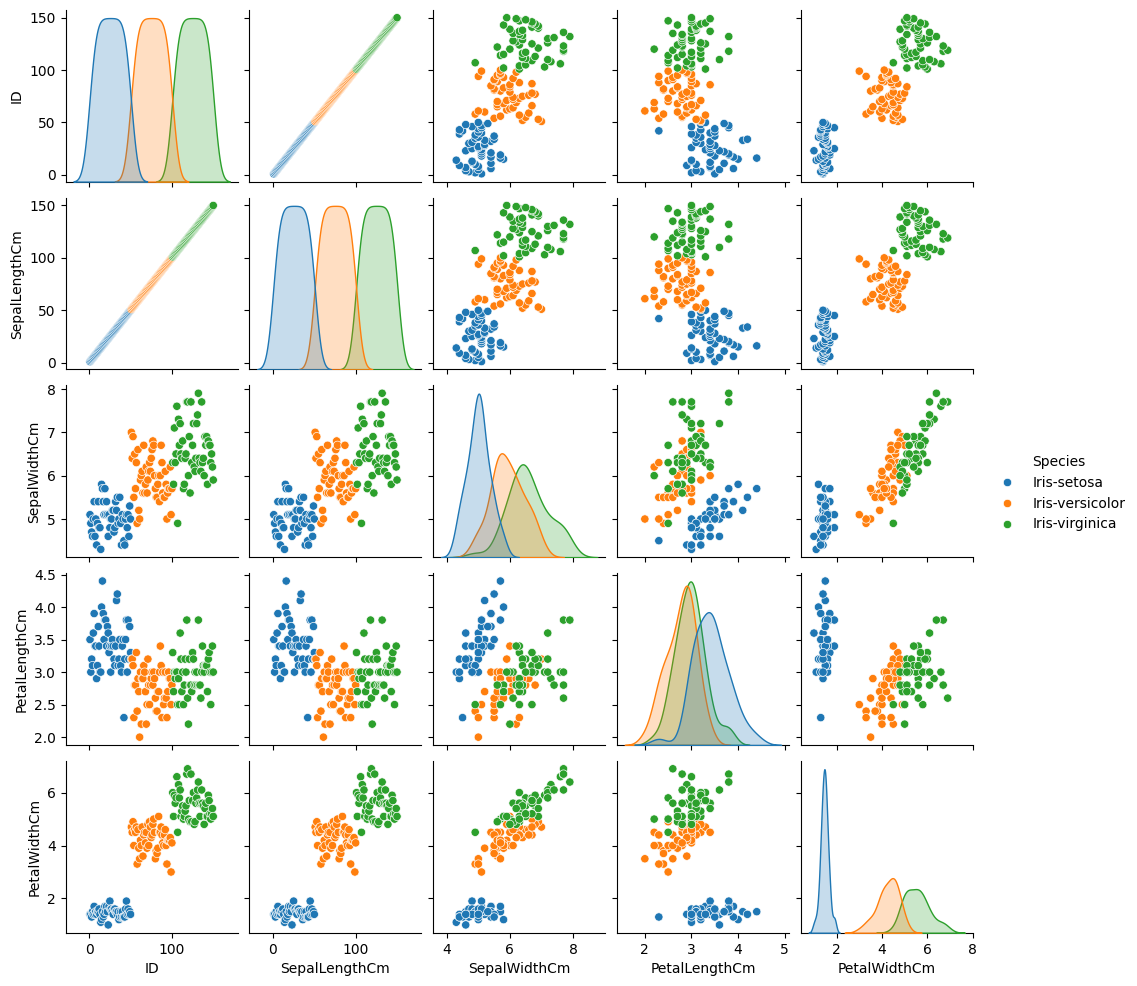

In [20]:
sns.pairplot(df, hue='Species', height=2)
plt.show()

In [14]:
# Checking distribution of the species over the entire dataset
species_counts = df['Species'].value_counts()
print("Species distribution in the entire dataset:")
print(species_counts)

Species distribution in the entire dataset:
Species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64


In [15]:
X = df.drop(columns=['Species'])
y = df['Species']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the distribution in train and test sets
train_distribution = pd.Series(y_train).value_counts()
test_distribution = pd.Series(y_test).value_counts()

print("\nSpecies distribution in the TRAINING set:")
print(train_distribution)

print("\nSpecies distribution in the TESTING set:")
print(test_distribution)


Species distribution in the TRAINING set:
Species
Iris-setosa        40
Iris-virginica     40
Iris-versicolor    40
Name: count, dtype: int64

Species distribution in the TESTING set:
Species
Iris-setosa        10
Iris-virginica     10
Iris-versicolor    10
Name: count, dtype: int64


### Data Exploration using yprofile and correlation matrix

In [16]:
# Generate a profile report using ydata-profiling
profile = ProfileReport(df, title="Iris Dataset Profiling Report", explorative=True)
profile.to_notebook_iframe()  # Display the report in a notebook (or save it to HTML if needed)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values)

# Check for capped values (e.g., outliers or unusual distributions)
print("\nSummary Statistics:")
print(df.describe())


Missing Values:
ID               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

Summary Statistics:
               ID  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
count  150.000000     150.000000    150.000000     150.000000    150.000000
mean    75.500000      75.500000      5.843333       3.054000      3.758667
std     43.445368      43.445368      0.828066       0.433594      1.764420
min      1.000000       1.000000      4.300000       2.000000      1.000000
25%     38.250000      38.250000      5.100000       2.800000      1.600000
50%     75.500000      75.500000      5.800000       3.000000      4.350000
75%    112.750000     112.750000      6.400000       3.300000      5.100000
max    150.000000     150.000000      7.900000       4.400000      6.900000


## Y DATA PROFILING


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

# Profile Report
profile = ProfileReport(df, title="Iris Dataset Profile Report", explorative=True)
profile.to_file("iris_profile_report.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## CORRELATION MATRIX

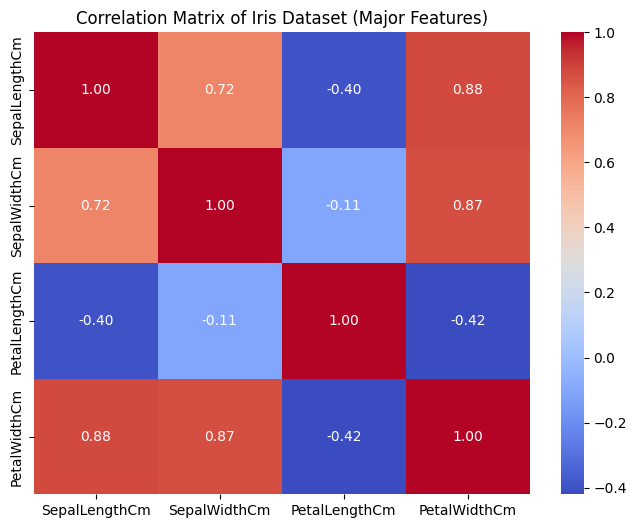

In [21]:
%matplotlib inline
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Display inline for Jupyter Notebook
%matplotlib inline

# Select features and calculate the correlation matrix
features = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
correlation_matrix = df[features].corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Iris Dataset (Major Features)")
plt.show()


## OUTLIER DETECTION

In [22]:
import pandas as pd

# Define a function to detect outliers using IQR
def find_outliers_iqr(data, features):
    outliers = {}
    for feature in features:
        Q1 = data[feature].quantile(0.25)  # First quartile
        Q3 = data[feature].quantile(0.75)  # Third quartile
        IQR = Q3 - Q1  # Interquartile Range
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[feature] = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
    return outliers

# Specify the features to check for outliers
features = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']

# Detect outliers
outliers = find_outliers_iqr(df, features)

# Display the outliers
for feature, outlier_data in outliers.items():
    print(f"Outliers in {feature}:")
    print(outlier_data)

Outliers in SepalLengthCm:
Empty DataFrame
Columns: [ID, SepalLengthCm, SepalWidthCm, PetalLengthCm, PetalWidthCm, Species]
Index: []
Outliers in SepalWidthCm:
Empty DataFrame
Columns: [ID, SepalLengthCm, SepalWidthCm, PetalLengthCm, PetalWidthCm, Species]
Index: []
Outliers in PetalLengthCm:
    ID  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
15  16           16.0           5.7            4.4           1.5   
32  33           33.0           5.2            4.1           1.5   
33  34           34.0           5.5            4.2           1.4   
60  61           61.0           5.0            2.0           3.5   

            Species  
15      Iris-setosa  
32      Iris-setosa  
33      Iris-setosa  
60  Iris-versicolor  
Outliers in PetalWidthCm:
Empty DataFrame
Columns: [ID, SepalLengthCm, SepalWidthCm, PetalLengthCm, PetalWidthCm, Species]
Index: []


## CAPPING OUTLIER

In [23]:
import pandas as pd

# Define a function to cap outliers using IQR
def cap_outliers_iqr(data, feature):
    Q1 = data[feature].quantile(0.25)  # First quartile
    Q3 = data[feature].quantile(0.75)  # Third quartile
    IQR = Q3 - Q1  # Interquartile Range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Replace outliers with bounds
    data[feature] = data[feature].apply(
        lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x)
    )
    return data

# Cap outliers in 'PetalLengthCm'
df = cap_outliers_iqr(df, 'PetalLengthCm')

# Display the updated DataFrame
print("Updated DataFrame after capping outliers in PetalLengthCm:")
print(df)


Updated DataFrame after capping outliers in PetalLengthCm:
      ID  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
0      1            1.0           5.1            3.5           1.4   
1      2            2.0           4.9            3.0           1.4   
2      3            3.0           4.7            3.2           1.3   
3      4            4.0           4.6            3.1           1.5   
4      5            5.0           5.0            3.6           1.4   
..   ...            ...           ...            ...           ...   
145  146          146.0           6.7            3.0           5.2   
146  147          147.0           6.3            2.5           5.0   
147  148          148.0           6.5            3.0           5.2   
148  149          149.0           6.2            3.4           5.4   
149  150          150.0           5.9            3.0           5.1   

            Species  
0       Iris-setosa  
1       Iris-setosa  
2       Iris-setosa  
3       Iris

In [26]:
df.head(150)

,ID,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,1.0,5.1,3.5,1.4,Iris-setosa
1,2,2.0,4.9,3.0,1.4,Iris-setosa
2,3,3.0,4.7,3.2,1.3,Iris-setosa
3,4,4.0,4.6,3.1,1.5,Iris-setosa
4,5,5.0,5.0,3.6,1.4,Iris-setosa
...,...,...,...,...,...,...
145,146,146.0,6.7,3.0,5.2,Iris-virginica
146,147,147.0,6.3,2.5,5.0,Iris-virginica
147,148,148.0,6.5,3.0,5.2,Iris-virginica
148,149,149.0,6.2,3.4,5.4,Iris-virginica


## EXPERIMENT 1 

#### LABEL ENCODING

In [29]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Sample dataset (replace with actual data loading code)
# Assuming df is your DataFrame
# df = pd.read_csv('path_to_your_dataset.csv')

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Species' column
df['Species_encoded'] = label_encoder.fit_transform(df['Species'])

# Display the mapping of species to encoded values
species_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Species Mapping:", species_mapping)

# Display the updated DataFrame
print(df.head(150))


Species Mapping: {'Iris-setosa': np.int64(0), 'Iris-versicolor': np.int64(1), 'Iris-virginica': np.int64(2)}
      ID  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
0      1            1.0           5.1            3.5           1.4   
1      2            2.0           4.9            3.0           1.4   
2      3            3.0           4.7            3.2           1.3   
3      4            4.0           4.6            3.1           1.5   
4      5            5.0           5.0            3.6           1.4   
..   ...            ...           ...            ...           ...   
145  146          146.0           6.7            3.0           5.2   
146  147          147.0           6.3            2.5           5.0   
147  148          148.0           6.5            3.0           5.2   
148  149          149.0           6.2            3.4           5.4   
149  150          150.0           5.9            3.0           5.1   

            Species  Species_encoded  
0       Iri

#### StandardScaleR

In [32]:
from sklearn.preprocessing import StandardScaler

# Select the numerical features to standardize
numerical_features = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']

# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the numerical features
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Display the standardized dataset
print(df.head())


   ID  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species  \
0   1      -1.720542     -0.900681       1.065722     -1.341272  Iris-setosa   
1   2      -1.697448     -1.143017      -0.120170     -1.341272  Iris-setosa   
2   3      -1.674353     -1.385353       0.354187     -1.398138  Iris-setosa   
3   4      -1.651258     -1.506521       0.117008     -1.284407  Iris-setosa   
4   5      -1.628164     -1.021849       1.302901     -1.341272  Iris-setosa   

   Species_encoded  
0                0  
1                0  
2                0  
3                0  
4                0  


#### CHECKING SKEWNESS 

In [33]:
# Check skewness of numerical features
skewness = df[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']].skew()
print(skewness)


SepalLengthCm    9.569869e-17
SepalWidthCm     3.149110e-01
PetalLengthCm    2.070941e-01
PetalWidthCm    -2.744643e-01
dtype: float64


EXPLANATION OF THE SKEWNESS 
Based on the skewness values you provided:

1. **Interpretation of Skewness**:
   - **SepalLengthCm**: \( 9.57 \times 10^{-17} \) (essentially 0) — Perfectly symmetric, no skewness.
   - **SepalWidthCm**: \( 0.315 \) — Slightly skewed, but well within acceptable limits.
   - **PetalLengthCm**: \( 0.207 \) — Slightly skewed, but well within acceptable limits.
   - **PetalWidthCm**: \( -0.274 \) — Slightly negatively skewed, but not extreme.

2. **Thresholds for Skewness**:
   - **Highly Skewed**: Skewness > 1 or < -1.
   - **Moderately Skewed**: Skewness between 0.5 and 1 (or -0.5 and -1).
   - **Symmetric/Minimal Skewness**: Skewness between -0.5 and 0.5.

3. **Do You Need Log Transformation?**
   - No. None of your features exhibit high or moderate skewness. All skewness values fall within the range of -0.5 to 0.5, which indicates symmetric data or minimal skewness.

4. **Conclusion**:
   - Log transformation is **not necessary** for your dataset as the skewness is minimal, and applying it might distort the already well-distributed features.

---



### LOGISTIC REGRESSION ON THE DATASET USING 3 FOLD WITHOUT HYPERPARAMETER TUNING

In [78]:
df

,ID,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,Species_encoded
0,1,-1.720542,-0.900681,1.065722,-1.341272,Iris-setosa,0
1,2,-1.697448,-1.143017,-0.120170,-1.341272,Iris-setosa,0
2,3,-1.674353,-1.385353,0.354187,-1.398138,Iris-setosa,0
3,4,-1.651258,-1.506521,0.117008,-1.284407,Iris-setosa,0
4,5,-1.628164,-1.021849,1.302901,-1.341272,Iris-setosa,0
...,...,...,...,...,...,...,...
145,146,1.628164,1.038005,-0.120170,0.819624,Iris-virginica,2
146,147,1.651258,0.553333,-1.306063,0.705893,Iris-virginica,2
147,148,1.674353,0.795669,-0.120170,0.819624,Iris-virginica,2
148,149,1.697448,0.432165,0.828544,0.933356,Iris-virginica,2


Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        50
Iris-versicolor       0.98      1.00      0.99        50
 Iris-virginica       1.00      0.98      0.99        50

       accuracy                           0.99       150
      macro avg       0.99      0.99      0.99       150
   weighted avg       0.99      0.99      0.99       150


Accuracy Score: 0.9933333333333333
F1 Score (Weighted): 0.9933326665999933

Confusion Matrix:
[[50  0  0]
 [ 0 50  0]
 [ 0  1 49]]


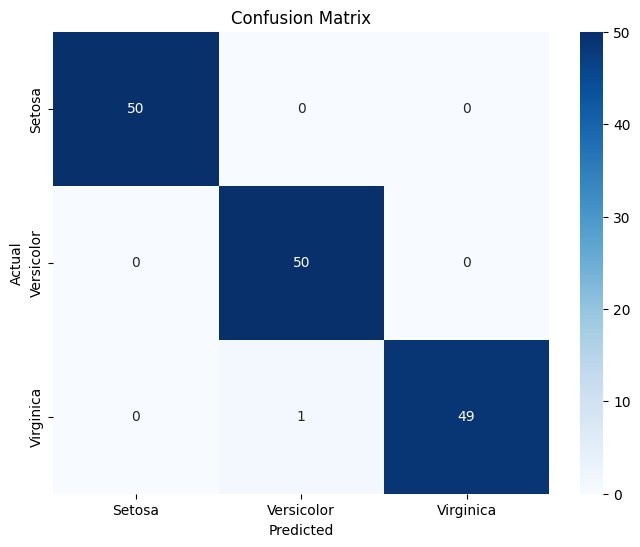

In [77]:
import numpy as np
from sklearn.model_selection import cross_val_predict, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Split features and target
X = df[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']].values
y = df['Species_encoded'].values

# Initialize Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=200)

# Perform 3-fold cross-validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
y_pred = cross_val_predict(log_reg, X, y, cv=skf)

# Train model and evaluate
accuracy = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred, average='weighted')
conf_matrix = confusion_matrix(y, y_pred)

# Print results
print("Classification Report:")
print(classification_report(y, y_pred, target_names=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']))
print("\nAccuracy Score:", accuracy)
print("F1 Score (Weighted):", f1)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Setosa', 'Versicolor', 'Virginica'], 
            yticklabels=['Setosa', 'Versicolor', 'Virginica'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


TESTING FOR ABOVE

In [79]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Assuming your dataframe is already defined as df
# Split features and target
X = df[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']].values
y = df['Species_encoded'].values

# Initialize Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=200)

# Train-test split (optional, but recommended for proper validation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model to training data
log_reg.fit(X_train, y_train)

# Define the function to predict species from user input
def predict_species(user_input):
    # Convert the user input to a NumPy array
    user_input_array = np.array(user_input).reshape(1, -1)
    
    # Perform the prediction
    prediction = log_reg.predict(user_input_array)
    
    # Mapping the encoded prediction back to the actual species name
    species_mapping = {0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}
    predicted_species = species_mapping[prediction[0]]
    
    return predicted_species

# Example: Get user input for features
print("Enter the features for prediction:")

# Input from the user for Sepal Length, Sepal Width, Petal Length, and Petal Width
SepalLengthCm = float(input("Enter SepalLengthCm: "))
SepalWidthCm = float(input("Enter SepalWidthCm: "))
PetalLengthCm = float(input("Enter PetalLengthCm: "))
PetalWidthCm = float(input("Enter PetalWidthCm: "))

# Create the user input list
user_input = [SepalLengthCm, SepalWidthCm, PetalLengthCm, PetalWidthCm]

# Predict the species
predicted_species = predict_species(user_input)
print(f"The predicted species is: {predicted_species}")


Enter the features for prediction:
The predicted species is: Iris-virginica


### LOGISTIC REGRESSION WITH Results—mean/std of CV results and results on the whole training data – add in parameter hyper tuning

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Hyperparameters: {'C': 10, 'max_iter': 100, 'solver': 'lbfgs'}

Cross-Validation Results:
Mean Accuracy: 0.9447, Standard Deviation: 0.0587

Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        50
Iris-versicolor       1.00      1.00      1.00        50
 Iris-virginica       1.00      1.00      1.00        50

       accuracy                           1.00       150
      macro avg       1.00      1.00      1.00       150
   weighted avg       1.00      1.00      1.00       150


Accuracy Score on Whole Data: 1.0
F1 Score (Weighted): 1.0

Confusion Matrix:
[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]


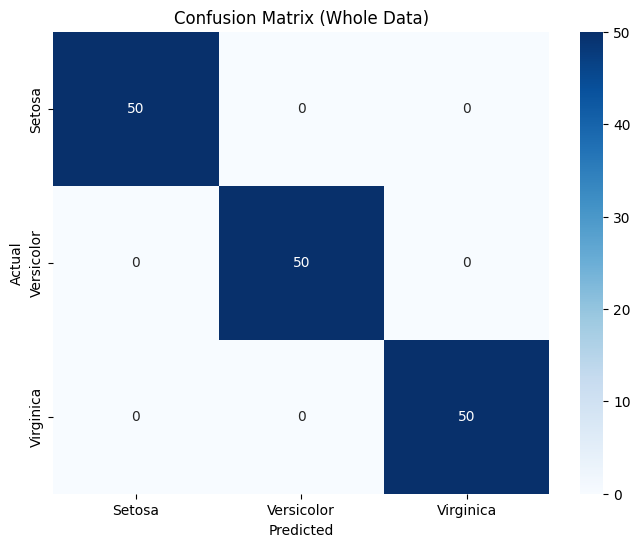

In [35]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Define parameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'lbfgs'],  # Solvers to try
    'max_iter': [100, 200, 300]  # Iterations
}

# Initialize the model
log_reg = LogisticRegression(random_state=42)

# Define Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=skf, scoring='accuracy', verbose=1)
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Results on the whole training data
y_pred = best_model.predict(X)

# Calculate mean/std for cross-validation results
cv_results = grid_search.cv_results_
mean_accuracy = np.mean(cv_results['mean_test_score'])
std_accuracy = np.std(cv_results['mean_test_score'])

# Accuracy metrics
accuracy = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred, average='weighted')
conf_matrix = confusion_matrix(y, y_pred)

# Print Results
print("Best Hyperparameters:", best_params)
print("\nCross-Validation Results:")
print(f"Mean Accuracy: {mean_accuracy:.4f}, Standard Deviation: {std_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y, y_pred, target_names=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']))
print("\nAccuracy Score on Whole Data:", accuracy)
print("F1 Score (Weighted):", f1)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Setosa', 'Versicolor', 'Virginica'], 
            yticklabels=['Setosa', 'Versicolor', 'Virginica'])
plt.title("Confusion Matrix (Whole Data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## RIDGE CLASSIFIER WITH HYPER PARAMETER TUNING

Fitting 3 folds for each of 35 candidates, totalling 105 fits
Best Hyperparameters for Ridge Classifier: {'alpha': 0.01, 'solver': 'auto'}

Cross-Validation Results:
Mean Accuracy: 0.8760, Standard Deviation: 0.0182

Classification Report (Whole Data):
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        50
Iris-versicolor       0.89      0.82      0.85        50
 Iris-virginica       0.83      0.90      0.87        50

       accuracy                           0.91       150
      macro avg       0.91      0.91      0.91       150
   weighted avg       0.91      0.91      0.91       150


Accuracy Score on Whole Data: 0.9066666666666666
F1 Score (Weighted): 0.9065170940170939

Confusion Matrix (Whole Data):
[[50  0  0]
 [ 0 41  9]
 [ 0  5 45]]


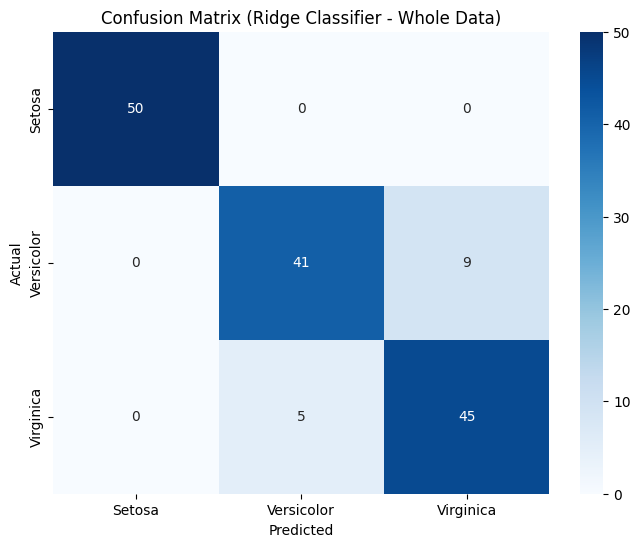

In [36]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import numpy as np

# Define parameter grid for Ridge Classifier
param_grid_ridge = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],  # Regularization strength
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

# Initialize Ridge Classifier
ridge_clf = RidgeClassifier()

# Stratified K-Fold Cross Validation
skf_ridge = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# GridSearchCV for Ridge Classifier
grid_search_ridge = GridSearchCV(estimator=ridge_clf, param_grid=param_grid_ridge, cv=skf_ridge, scoring='accuracy', verbose=1)
grid_search_ridge.fit(X, y)

# Best model and parameters
best_ridge_model = grid_search_ridge.best_estimator_
best_ridge_params = grid_search_ridge.best_params_

# Results on the whole training data
y_ridge_pred = best_ridge_model.predict(X)

# Calculate mean/std for cross-validation results
cv_results_ridge = grid_search_ridge.cv_results_
mean_ridge_accuracy = np.mean(cv_results_ridge['mean_test_score'])
std_ridge_accuracy = np.std(cv_results_ridge['mean_test_score'])

# Accuracy metrics
ridge_accuracy = accuracy_score(y, y_ridge_pred)
ridge_f1 = f1_score(y, y_ridge_pred, average='weighted')
ridge_conf_matrix = confusion_matrix(y, y_ridge_pred)

# Print Results
print("Best Hyperparameters for Ridge Classifier:", best_ridge_params)
print("\nCross-Validation Results:")
print(f"Mean Accuracy: {mean_ridge_accuracy:.4f}, Standard Deviation: {std_ridge_accuracy:.4f}")
print("\nClassification Report (Whole Data):")
print(classification_report(y, y_ridge_pred, target_names=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']))
print("\nAccuracy Score on Whole Data:", ridge_accuracy)
print("F1 Score (Weighted):", ridge_f1)
print("\nConfusion Matrix (Whole Data):")
print(ridge_conf_matrix)

# Plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(ridge_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Setosa', 'Versicolor', 'Virginica'], 
            yticklabels=['Setosa', 'Versicolor', 'Virginica'])
plt.title("Confusion Matrix (Ridge Classifier - Whole Data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## RANDOM FOREST CLASSIFIER WITH HYPER PARAMETER TUNING

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Hyperparameters for Random Forest Classifier: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Cross-Validation Results:
Mean Accuracy: 0.9973, Standard Deviation: 0.0033

Classification Report (Whole Data):
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        50
Iris-versicolor       1.00      1.00      1.00        50
 Iris-virginica       1.00      1.00      1.00        50

       accuracy                           1.00       150
      macro avg       1.00      1.00      1.00       150
   weighted avg       1.00      1.00      1.00       150


Accuracy Score on Whole Data: 1.0
F1 Score (Weighted): 1.0

Confusion Matrix (Whole Data):
[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]


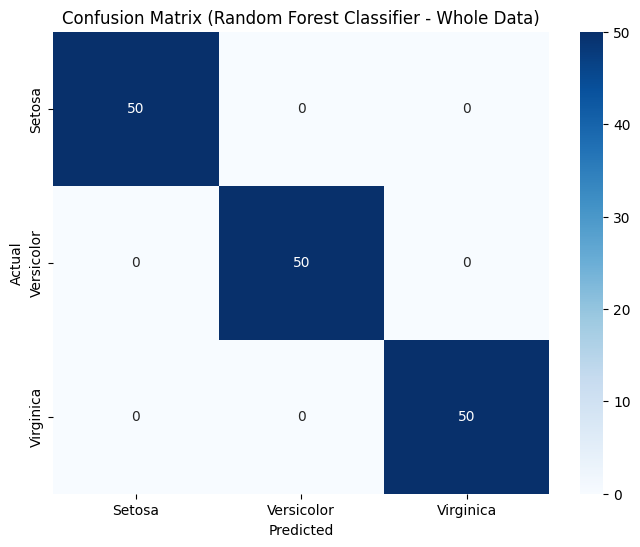

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],        # Number of trees
    'max_depth': [None, 10, 20, 30],      # Maximum depth of trees
    'min_samples_split': [2, 5, 10],      # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],        # Minimum samples in a leaf node
    'bootstrap': [True, False]            # Whether to use bootstrap sampling
}

# Initialize Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)

# Stratified K-Fold Cross Validation
skf_rf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# GridSearchCV for Random Forest Classifier
grid_search_rf = GridSearchCV(estimator=rf_clf, param_grid=param_grid_rf, cv=skf_rf, scoring='accuracy', verbose=1)
grid_search_rf.fit(X, y)

# Best model and parameters
best_rf_model = grid_search_rf.best_estimator_
best_rf_params = grid_search_rf.best_params_

# Results on the whole training data
y_rf_pred = best_rf_model.predict(X)

# Calculate mean/std for cross-validation results
cv_results_rf = grid_search_rf.cv_results_
mean_rf_accuracy = np.mean(cv_results_rf['mean_test_score'])
std_rf_accuracy = np.std(cv_results_rf['mean_test_score'])

# Accuracy metrics
rf_accuracy = accuracy_score(y, y_rf_pred)
rf_f1 = f1_score(y, y_rf_pred, average='weighted')
rf_conf_matrix = confusion_matrix(y, y_rf_pred)

# Print Results
print("Best Hyperparameters for Random Forest Classifier:", best_rf_params)
print("\nCross-Validation Results:")
print(f"Mean Accuracy: {mean_rf_accuracy:.4f}, Standard Deviation: {std_rf_accuracy:.4f}")
print("\nClassification Report (Whole Data):")
print(classification_report(y, y_rf_pred, target_names=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']))
print("\nAccuracy Score on Whole Data:", rf_accuracy)
print("F1 Score (Weighted):", rf_f1)
print("\nConfusion Matrix (Whole Data):")
print(rf_conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Setosa', 'Versicolor', 'Virginica'], 
            yticklabels=['Setosa', 'Versicolor', 'Virginica'])
plt.title("Confusion Matrix (Random Forest Classifier - Whole Data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [38]:
df

,ID,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,Species_encoded
0,1,-1.720542,-0.900681,1.065722,-1.341272,Iris-setosa,0
1,2,-1.697448,-1.143017,-0.120170,-1.341272,Iris-setosa,0
2,3,-1.674353,-1.385353,0.354187,-1.398138,Iris-setosa,0
3,4,-1.651258,-1.506521,0.117008,-1.284407,Iris-setosa,0
4,5,-1.628164,-1.021849,1.302901,-1.341272,Iris-setosa,0
...,...,...,...,...,...,...,...
145,146,1.628164,1.038005,-0.120170,0.819624,Iris-virginica,2
146,147,1.651258,0.553333,-1.306063,0.705893,Iris-virginica,2
147,148,1.674353,0.795669,-0.120170,0.819624,Iris-virginica,2
148,149,1.697448,0.432165,0.828544,0.933356,Iris-virginica,2


## XGBOOST

Accuracy on Test Data: 1.0
F1 Score (Weighted): 1.0

Classification Report (Test Data):
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        19
Iris-versicolor       1.00      1.00      1.00        13
 Iris-virginica       1.00      1.00      1.00        13

       accuracy                           1.00        45
      macro avg       1.00      1.00      1.00        45
   weighted avg       1.00      1.00      1.00        45


Confusion Matrix:
[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]


c:\Users\chanc\Desktop\ZIA FINAL PROJECT\EASF\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:52:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


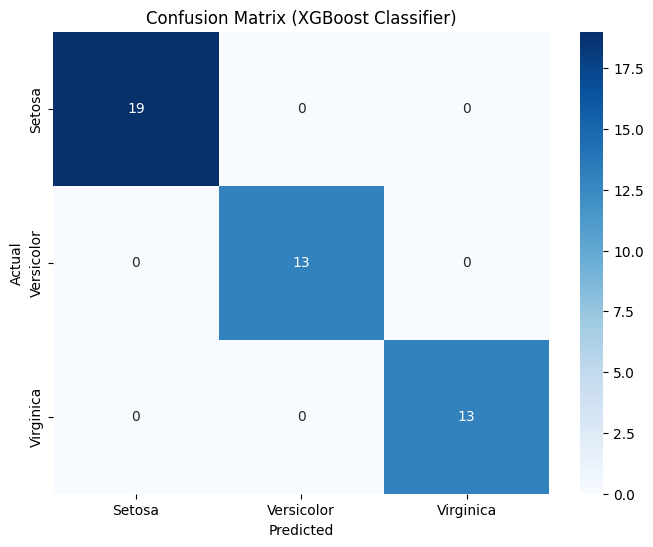

In [45]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your data is in X (features) and y (target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the XGBClassifier
xgb_clf = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Train the model
xgb_clf.fit(X_train, y_train)

# Predictions
y_pred = xgb_clf.predict(X_test)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print("Accuracy on Test Data:", accuracy)
print("F1 Score (Weighted):", f1)
print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_pred, target_names=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']))
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Setosa', 'Versicolor', 'Virginica'], 
            yticklabels=['Setosa', 'Versicolor', 'Virginica'])
plt.title("Confusion Matrix (XGBoost Classifier)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# BREEEEAAAAAAAAAAAAAAAAAAKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK

## Experiment #3: Perform feature engineering and attribute combination. 

In [46]:
import pandas as pd
import numpy as np

# Assuming your original dataframe is 'df'
df_new = df.copy()

# 1. Create interaction features
df_new['SepalRatio'] = df_new['SepalLengthCm'] / df_new['SepalWidthCm']
df_new['PetalRatio'] = df_new['PetalLengthCm'] / df_new['PetalWidthCm']
df_new['SepalPetalArea'] = df_new['SepalLengthCm'] * df_new['PetalLengthCm']

# 2. Create polynomial features (for example, square the PetalLengthCm)
df_new['PetalLengthSquared'] = df_new['PetalLengthCm'] ** 2

# 3. Create binning features
df_new['SepalLengthBin'] = pd.cut(df_new['SepalLengthCm'], bins=[0, 4, 5, 6, 8], labels=['Short', 'Medium', 'Long', 'Very Long'])
df_new['PetalWidthBin'] = pd.cut(df_new['PetalWidthCm'], bins=[0, 1.2, 2.0, 3.0], labels=['Thin', 'Medium', 'Wide'])

# 4. Apply log transformation (e.g., on highly skewed features like PetalLengthCm)
df_new['Log_PetalLengthCm'] = np.log1p(df_new['PetalLengthCm'])

# 5. Create additional features based on domain knowledge or data insight
df_new['SepalSize'] = df_new['SepalLengthCm'] * df_new['SepalWidthCm']  # Sepal area as a new feature

# Display new dataframe with engineered features
print(df_new.head())


   ID  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species  \
0   1      -1.720542     -0.900681       1.065722     -1.341272  Iris-setosa   
1   2      -1.697448     -1.143017      -0.120170     -1.341272  Iris-setosa   
2   3      -1.674353     -1.385353       0.354187     -1.398138  Iris-setosa   
3   4      -1.651258     -1.506521       0.117008     -1.284407  Iris-setosa   
4   5      -1.628164     -1.021849       1.302901     -1.341272  Iris-setosa   

   Species_encoded  SepalRatio  PetalRatio  SepalPetalArea  \
0                0    1.910268   -0.794561       -1.833620   
1                0    1.485059    0.089594        0.203983   
2                0    1.208611   -0.253327       -0.593033   
3                0    1.096074   -0.091099       -0.193211   
4                0    1.593351   -0.971392       -2.121336   

   PetalLengthSquared SepalLengthBin PetalWidthBin  Log_PetalLengthCm  \
0            1.135764            NaN           NaN           0.725480   


c:\Users\chanc\Desktop\ZIA FINAL PROJECT\EASF\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [50]:
df_new

,ID,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,Species_encoded,SepalRatio,PetalRatio,SepalPetalArea,PetalLengthSquared,SepalLengthBin,PetalWidthBin,Log_PetalLengthCm,SepalSize
0,1,-1.720542,-0.900681,1.065722,-1.341272,Iris-setosa,0,1.910268,-0.794561,-1.833620,1.135764,NaN,NaN,0.725480,1.549660
1,2,-1.697448,-1.143017,-0.120170,-1.341272,Iris-setosa,0,1.485059,0.089594,0.203983,0.014441,NaN,NaN,-0.128027,1.940211
2,3,-1.674353,-1.385353,0.354187,-1.398138,Iris-setosa,0,1.208611,-0.253327,-0.593033,0.125448,NaN,NaN,0.303201,2.319569
3,4,-1.651258,-1.506521,0.117008,-1.284407,Iris-setosa,0,1.096074,-0.091099,-0.193211,0.013691,NaN,NaN,0.110654,2.487655
4,5,-1.628164,-1.021849,1.302901,-1.341272,Iris-setosa,0,1.593351,-0.971392,-2.121336,1.697550,NaN,NaN,0.834170,1.663738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,1.628164,1.038005,-0.120170,0.819624,Iris-virginica,2,1.568552,-0.146617,-0.195657,0.014441,Short,Thin,-0.128027,1.690042
146,147,1.651258,0.553333,-1.306063,0.705893,Iris-virginica,2,2.984202,-1.850228,-2.156648,1.705801,Short,Thin,NaN,0.913696
147,148,1.674353,0.795669,-0.120170,0.819624,Iris-virginica,2,2.104334,-0.146617,-0.201208,0.014441,Short,Thin,-0.128027,1.332231
148,149,1.697448,0.432165,0.828544,0.933356,Iris-virginica,2,3.927773,0.887704,1.406409,0.686485,Short,Thin,0.603520,0.733578


## Experiment #4: Perform feature selection using Correlation Threshold, Feature Importance, and Variance Threshold

In [51]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_new is your DataFrame

# Step 1: Correlation Threshold
# Exclude non-numeric columns (like 'ID' and 'Species')
numeric_df = df_new.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Set a threshold for correlation (e.g., 0.85)
threshold = 0.85
# Identify columns to drop based on correlation threshold
correlated_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            correlated_features.add(colname)

# Drop correlated features from the dataset
df_corr_selected = df_new.drop(columns=correlated_features)
print(f"Features dropped due to correlation: {correlated_features}")
print(f"Shape of dataset after correlation threshold: {df_corr_selected.shape}")

# Step 2: Feature Encoding
# One-hot encode categorical columns like 'SepalLengthBin', 'PetalWidthBin'
df_corr_selected_encoded = pd.get_dummies(df_corr_selected, columns=['SepalLengthBin', 'PetalWidthBin'])

# Label encode the target column 'Species'
label_encoder = LabelEncoder()
df_corr_selected_encoded['Species_encoded'] = label_encoder.fit_transform(df_corr_selected_encoded['Species'])

# Prepare features and target
X = df_corr_selected_encoded.drop(columns=['ID', 'Species', 'Species_encoded'])
y = df_corr_selected_encoded['Species_encoded']

# Step 3: Feature Importance (Random Forest)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X, y)

# Get feature importances
feature_importances = pd.Series(rf_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importances:")
print(feature_importances)

# Select top N important features (e.g., top 5)
top_n = 5
selected_features = feature_importances.head(top_n).index
df_rf_selected = df_corr_selected_encoded[selected_features.tolist() + ['Species_encoded']]

print(f"Selected features based on Random Forest Importance: {selected_features}")
print(f"Shape of dataset after feature importance selection: {df_rf_selected.shape}")

# Step 4: Variance Threshold
# Initialize VarianceThreshold with a threshold of 0.01 (or any desired threshold)
var_thresh = VarianceThreshold(threshold=0.01)
X_var_thresh = var_thresh.fit_transform(X)

# Get the feature names that are selected after applying variance threshold
selected_columns = X.columns[var_thresh.get_support()]
df_var_selected = df_corr_selected_encoded[selected_columns.tolist() + ['Species_encoded']]

print(f"Features selected after variance threshold: {selected_columns}")
print(f"Shape of dataset after variance threshold selection: {df_var_selected.shape}")

# Display the results of feature selection
print("\nFinal Datasets After Feature Selection:")
print(f"After Correlation Threshold: {df_corr_selected_encoded.shape}")
print(f"After Feature Importance: {df_rf_selected.shape}")
print(f"After Variance Threshold: {df_var_selected.shape}")


Features dropped due to correlation: {'Log_PetalLengthCm', 'PetalWidthCm', 'Species_encoded', 'SepalLengthCm'}
Shape of dataset after correlation threshold: (150, 11)
Feature Importances:
SepalSize                   0.213205
SepalWidthCm                0.175318
SepalLengthBin_Short        0.153165
SepalRatio                  0.126128
PetalWidthBin_Thin          0.093955
SepalPetalArea              0.088567
PetalLengthCm               0.057617
PetalRatio                  0.054162
PetalWidthBin_Medium        0.018972
PetalLengthSquared          0.018911
SepalLengthBin_Long         0.000000
SepalLengthBin_Medium       0.000000
SepalLengthBin_Very Long    0.000000
PetalWidthBin_Wide          0.000000
dtype: float64
Selected features based on Random Forest Importance: Index(['SepalSize', 'SepalWidthCm', 'SepalLengthBin_Short', 'SepalRatio',
       'PetalWidthBin_Thin'],
      dtype='object')
Shape of dataset after feature importance selection: (150, 6)
Features selected after variance thres

## Experiment #5: Use PCA for dimensionality reduction on all the features. Create a scree plot to show which components will be selected for classification. 

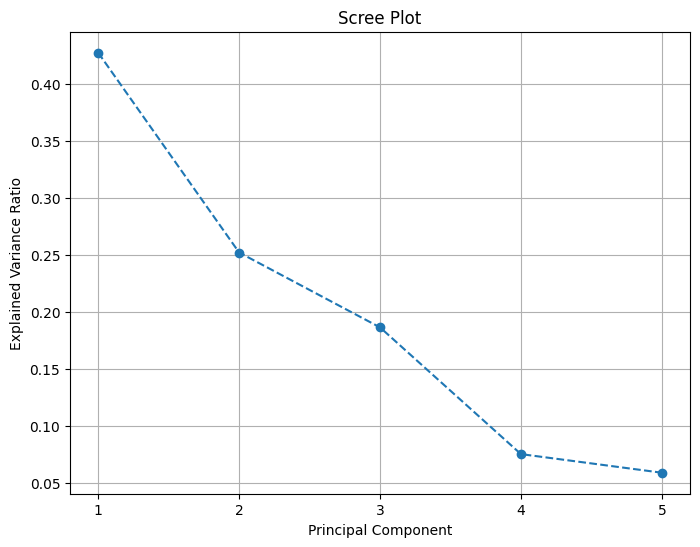

Cumulative explained variance: [0.4270936  0.6791315  0.86555064 0.94093096 1.        ]
Number of components selected for 90% variance: 4


In [62]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Select the features for PCA
# We will use the df_rf_selected dataset, which includes the top 5 features based on Random Forest importance
X_selected = df_rf_selected.drop(columns=['Species_encoded'])  # Drop target column

# Step 2: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Step 3: Apply PCA to the scaled data
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Step 4: Create a scree plot to show the explained variance of each component
explained_variance = pca.explained_variance_ratio_

# Plotting the scree plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True)
plt.show()

# Step 5: Decide how many components to select based on the scree plot
# Typically, you want to select components that explain at least 80-90% of the variance
cumulative_variance = np.cumsum(explained_variance)
print(f"Cumulative explained variance: {cumulative_variance}")

# You can select the number of components based on your desired threshold (e.g., 90%)
n_components = np.argmax(cumulative_variance >= 0.90) + 1  # +1 because index starts from 0
print(f"Number of components selected for 90% variance: {n_components}")


## CUSTOM 1 RANDOM FOREST CLASSIFIER

Classification Report for RF with PCA Features:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      0.85      0.92        13
           2       0.93      1.00      0.96        13

    accuracy                           0.96        45
   macro avg       0.96      0.95      0.95        45
weighted avg       0.96      0.96      0.95        45

Accuracy: 0.9555555555555556
Confusion Matrix:
[[19  0  0]
 [ 1 11  1]
 [ 0  0 13]]


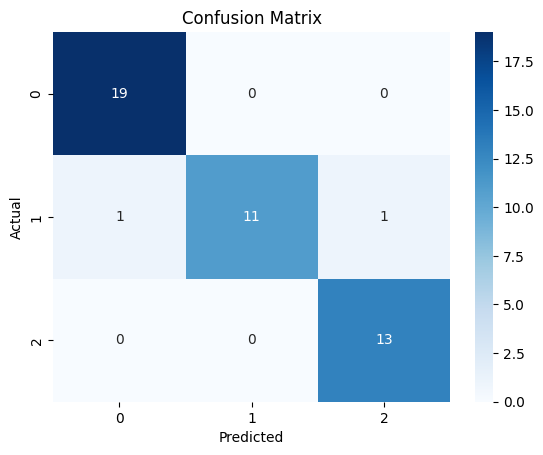

In [67]:
# Step 6: Reduce the dataset to the first 4 principal components
pca = PCA(n_components=4)
X_reduced = pca.fit_transform(X_scaled)

# Step 7: Split the reduced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

# Step 8: Train a classifier (e.g., Random Forest) on the reduced dataset
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Step 9: Predict and evaluate the model
y_pred = rf_clf.predict(X_test)

# Print accuracy and confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix


accuracy = accuracy_score(y_test, y_pred)

# Classification report for SVM with PCA features
print("Classification Report for RF with PCA Features:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## CUSTOM 2 SVC

Accuracy with PCA features: 0.9333


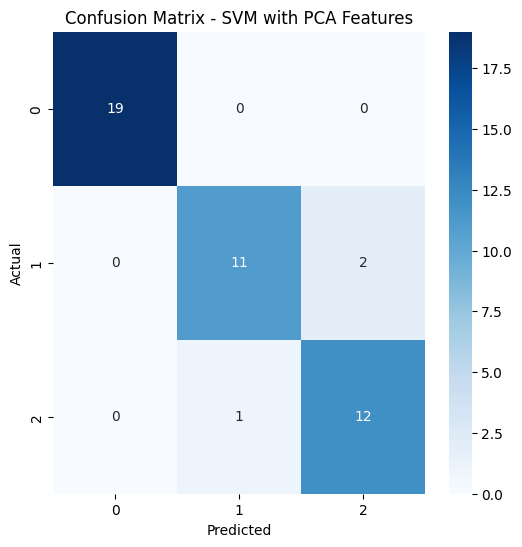

Classification Report for SVM with PCA Features:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.92      0.85      0.88        13
           2       0.86      0.92      0.89        13

    accuracy                           0.93        45
   macro avg       0.92      0.92      0.92        45
weighted avg       0.93      0.93      0.93        45



In [66]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_rf_selected is your DataFrame after feature selection based on Random Forest Importance

# Step 1: Prepare the features and target
X = df_rf_selected.drop(columns=['Species_encoded'])
y = df_rf_selected['Species_encoded']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Apply PCA for dimensionality reduction (retaining 90% of variance)
pca = PCA(n_components=4)  # Based on your previous PCA output
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Step 4: Train SVM classifier using the PCA-reduced features
svm_pca = SVC(kernel='linear', random_state=42)  # You can use other kernels like 'rbf' or 'poly' as well
svm_pca.fit(X_train_pca, y_train)

# Step 5: Evaluate the model on the test set

# Predictions using the PCA features
y_pred_pca = svm_pca.predict(X_test_pca)

# Accuracy of the SVM classifier
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f"Accuracy with PCA features: {accuracy_pca:.4f}")

# Confusion Matrix for PCA features
cm_pca = confusion_matrix(y_test, y_pred_pca)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_pca, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - SVM with PCA Features")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification report for SVM with PCA features
print("Classification Report for SVM with PCA Features:")
print(classification_report(y_test, y_pred_pca))



# Create meaningful F1-score plots to compare experiments and determine the best model.

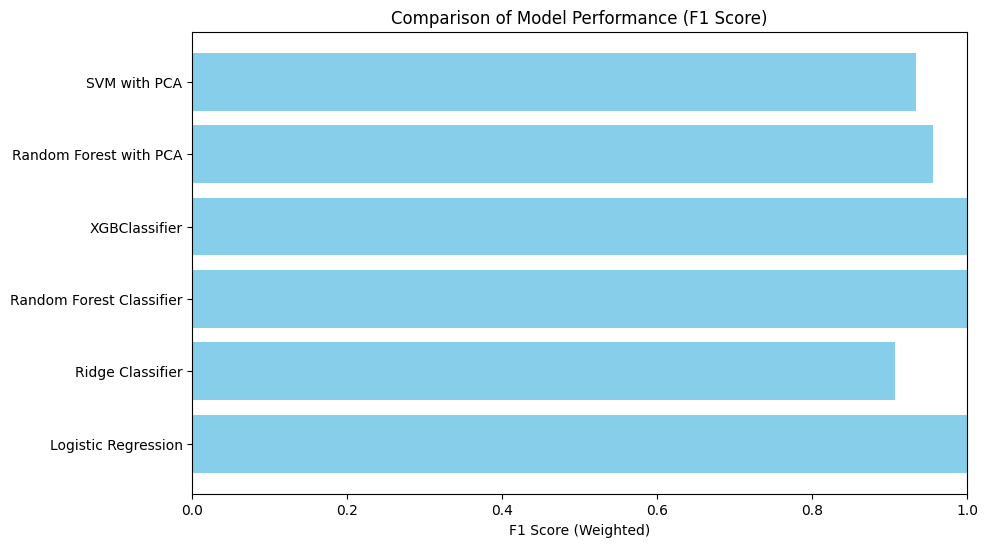

Logistic Regression: F1 Score = 1.0000
Ridge Classifier: F1 Score = 0.9065
Random Forest Classifier: F1 Score = 1.0000
XGBClassifier: F1 Score = 1.0000
Random Forest with PCA: F1 Score = 0.9556
SVM with PCA: F1 Score = 0.9333


In [68]:
import matplotlib.pyplot as plt

# Model names and corresponding F1-scores
models = [
    'Logistic Regression',
    'Ridge Classifier',
    'Random Forest Classifier',
    'XGBClassifier',
    'Random Forest with PCA',
    'SVM with PCA'
]

f1_scores = [
    1.0,  # Logistic Regression
    0.9065,  # Ridge Classifier
    1.0,  # Random Forest Classifier
    1.0,  # XGBClassifier
    0.9556,  # Random Forest with PCA
    0.9333  # SVM with PCA
]

# Create a bar plot to compare the F1-scores of each model
plt.figure(figsize=(10, 6))
plt.barh(models, f1_scores, color='skyblue')
plt.xlabel('F1 Score (Weighted)')
plt.title('Comparison of Model Performance (F1 Score)')
plt.xlim(0, 1)  # Set the x-axis to range from 0 to 1
plt.show()

# Print the F1 scores for reference
for model, score in zip(models, f1_scores):
    print(f'{model}: F1 Score = {score:.4f}')


# BREAK

Experiment #2: Create a pipeline for preprocessing and use RidgeClassifier, 

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import numpy as np

# Features and target
X = df_final  # Preprocessed numerical features
y = df['Species']  # Original target variable

# Encode target variable
y_encoded = pd.factorize(y)[0]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("scale", StandardScaler(), X.columns)  # Apply StandardScaler to numerical columns
    ]
)

# Complete pipeline with RidgeClassifier
ridge_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RidgeClassifier(alpha=1.0))  # Default regularization parameter alpha=1.0
])

# Train the pipeline
ridge_pipeline.fit(X_train, y_train)

# Evaluate on test data
y_test_pred = ridge_pipeline.predict(X_test)

# Cross-validation
cv_scores = cross_val_score(ridge_pipeline, X_train, y_train, cv=3, scoring="f1_weighted")
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)

# Test metrics
accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred, average="weighted")
precision = precision_score(y_test, y_test_pred, average="weighted")
recall = recall_score(y_test, y_test_pred, average="weighted")

# Display results
print(f"Cross-Validation Results (3-fold): Mean F1 = {cv_mean:.4f}, Std = {cv_std:.4f}")
print(f"Test Results: Accuracy = {accuracy:.4f}, F1 Score = {f1:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}")

# Detailed classification report and confusion matrix
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=df['Species'].unique()))

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Cross-Validation Results (3-fold): Mean F1 = 1.0000, Std = 0.0000
Test Results: Accuracy = 1.0000, F1 Score = 1.0000, Precision = 1.0000, Recall = 1.0000

Test Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00        10
 Iris-virginica       1.00      1.00      1.00        10

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30


Test Confusion Matrix:
[[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]


RANDOM FOREST CLASSIFIER

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import numpy as np

# Features and target
X = df_final  # Preprocessed features
y = df['Species']  # Target variable

# Encode the target variable
y_encoded = pd.factorize(y)[0]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("scale", StandardScaler(), X.columns)  # StandardScaler for numerical features
    ]
)

# Complete pipeline with RandomForestClassifier
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the pipeline
rf_pipeline.fit(X_train, y_train)

# Evaluate on test data
y_test_pred = rf_pipeline.predict(X_test)

# Cross-validation
cv_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=3, scoring="f1_weighted")
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)

# Test metrics
accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred, average="weighted")
precision = precision_score(y_test, y_test_pred, average="weighted")
recall = recall_score(y_test, y_test_pred, average="weighted")

# Display results
print(f"Cross-Validation Results (3-fold): Mean F1 = {cv_mean:.4f}, Std = {cv_std:.4f}")
print(f"Test Results: Accuracy = {accuracy:.4f}, F1 Score = {f1:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}")

# Detailed classification report and confusion matrix
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=df['Species'].unique()))

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Cross-Validation Results (3-fold): Mean F1 = 1.0000, Std = 0.0000
Test Results: Accuracy = 1.0000, F1 Score = 1.0000, Precision = 1.0000, Recall = 1.0000

Test Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00        10
 Iris-virginica       1.00      1.00      1.00        10

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30


Test Confusion Matrix:
[[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]


XGBClassifier

In [42]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

# Assuming 'df_final' contains preprocessed features
X = df_final
y = df['Species']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 1.0000

Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00        10
 Iris-virginica       1.00      1.00      1.00        10

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30


Confusion Matrix:
[[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]


c:\Users\chanc\Desktop\ZIA FINAL PROJECT\EASF\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:41:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Experiment #3: Perform feature engineering and attribute combination. 

In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Assuming df is your preprocessed DataFrame
# Feature engineering - create new features based on combinations
df['SepalLength_to_SepalWidth'] = df['SepalLengthCm'] / df['SepalWidthCm']
df['PetalLength_to_PetalWidth'] = df['PetalLengthCm'] / df['PetalWidthCm']
df['SepalLength_times_SepalWidth'] = df['SepalLengthCm'] * df['SepalWidthCm']
df['PetalLength_times_PetalWidth'] = df['PetalLengthCm'] * df['PetalWidthCm']
df['SepalArea'] = df['SepalLengthCm'] * df['SepalWidthCm']
df['PetalArea'] = df['PetalLengthCm'] * df['PetalWidthCm']

# Adding polynomial features (e.g., squares)
df['SepalLength_squared'] = df['SepalLengthCm'] ** 2
df['PetalLength_squared'] = df['PetalLengthCm'] ** 2

# Interaction term (e.g., sum of Sepal and Petal lengths)
df['Sepal_Petal_Length_Sum'] = df['SepalLengthCm'] + df['PetalLengthCm']

# Splitting data into features and target
X = df.drop(columns=['Species', 'ID'])  # Dropping target and any irrelevant columns
y = pd.factorize(df['Species'])[0]  # Encoding target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a RandomForestClassifier on the engineered features
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)

# Classification report and accuracy metrics
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Test Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



Experiment #4: Perform feature selection using Correlation Threshold, Feature Importance, and Variance Threshold

Shape after correlation threshold: (150, 6)


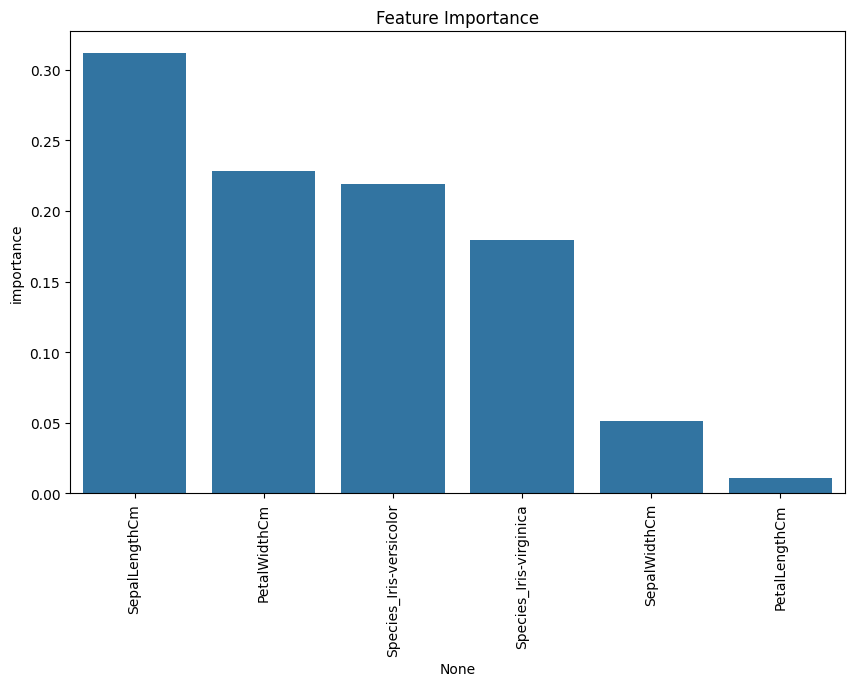

Shape after feature importance filtering: (150, 6)
Shape after variance threshold filtering: (150, 2)
Accuracy: 1.0
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00         9
 Iris-virginica       1.00      1.00      1.00        11

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30



In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_final is your preprocessed data (features), and df['Species'] is your target

# Step 1: Correlation Threshold
def correlation_threshold(X, threshold=0.9):
    # Calculate the correlation matrix
    corr_matrix = X.corr().abs()
    
    # Upper triangle of the correlation matrix (we don't need to check for duplicate correlations)
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Get columns with correlation greater than the threshold
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    
    # Drop the highly correlated columns
    X_filtered = X.drop(columns=to_drop)
    return X_filtered

# Step 2: Feature Importance using RandomForest
def feature_importance(X, y):
    # Fit a RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # Get the feature importance
    feature_importances = pd.DataFrame(rf.feature_importances_,
                                       index=X.columns,
                                       columns=["importance"]).sort_values("importance", ascending=False)
    
    # Optionally plot the feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances.index, y=feature_importances['importance'])
    plt.xticks(rotation=90)
    plt.title('Feature Importance')
    plt.show()
    
    return feature_importances

# Step 3: Variance Threshold
def variance_threshold(X, threshold=0.1):
    # Initialize VarianceThreshold
    selector = VarianceThreshold(threshold)
    
    # Fit the selector and transform the data
    X_filtered = selector.fit_transform(X)
    
    # Get the selected columns
    selected_columns = X.columns[selector.get_support()]
    X_filtered_df = pd.DataFrame(X_filtered, columns=selected_columns)
    
    return X_filtered_df

# Assuming df_final is the features and df['Species'] is the target
X = df_final  # Features
y = df['Species']  # Target

# Apply Correlation Threshold
X_corr_filtered = correlation_threshold(X, threshold=0.9)
print(f"Shape after correlation threshold: {X_corr_filtered.shape}")

# Apply Feature Importance
feature_importances = feature_importance(X_corr_filtered, y)
important_features = feature_importances[feature_importances['importance'] > 0.01].index
X_important_filtered = X_corr_filtered[important_features]
print(f"Shape after feature importance filtering: {X_important_filtered.shape}")

# Apply Variance Threshold
X_variance_filtered = variance_threshold(X_important_filtered, threshold=0.1)
print(f"Shape after variance threshold filtering: {X_variance_filtered.shape}")

# Train a model using the filtered data (e.g., RandomForestClassifier)
X_train, X_test, y_train, y_test = train_test_split(X_variance_filtered, y, test_size=0.2, random_state=42)

# Train the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_classifier.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Experiment #5: Use PCA for dimensionality reduction on all the features. Create a scree plot to show which components will be selected for classification. 

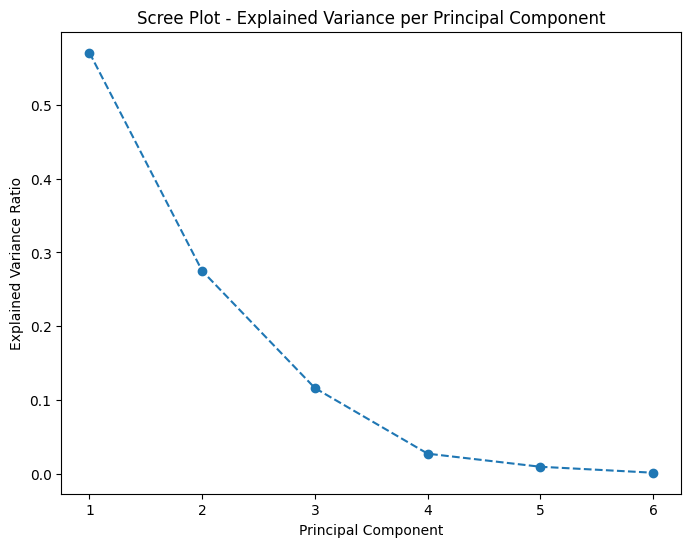

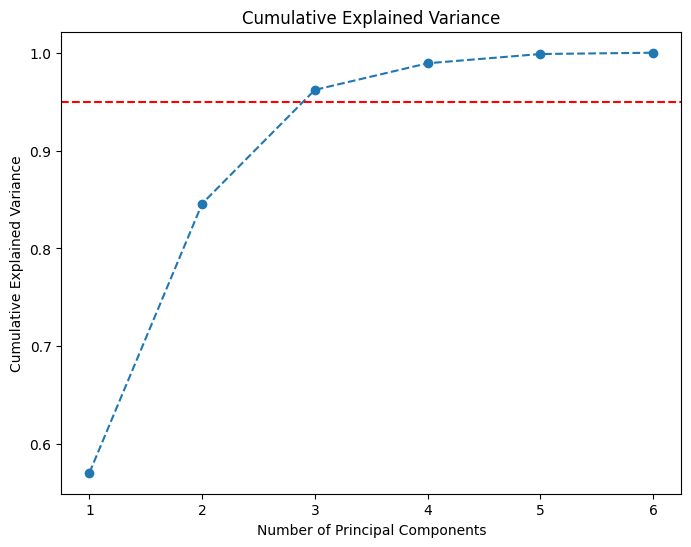

Accuracy: 1.0
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00        10
 Iris-virginica       1.00      1.00      1.00        10

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30



In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Assuming df_final is the preprocessed feature dataframe
X = df_final  # Preprocessed features
y = df['Species']  # Target variable

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Scree plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot - Explained Variance per Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Plot cumulative variance to decide the number of components to keep
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--')  # Usually, we choose components that explain at least 95% variance
plt.show()

# Select the number of components based on the scree plot
n_components = np.argmax(cumulative_variance >= 0.95) + 1  # For 95% explained variance

# Apply PCA with the selected number of components
pca = PCA(n_components=n_components)
X_pca_selected = pca.fit_transform(X_scaled)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca_selected, y, test_size=0.2, random_state=42, stratify=y)

# Train a classifier (RandomForest for example)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Experiment #6: Design and execute a custom experiment

c:\Users\chanc\Desktop\ZIA FINAL PROJECT\EASF\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:52:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\chanc\Desktop\ZIA FINAL PROJECT\EASF\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:52:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


           Scaler          Classifier  Accuracy  F1 Score  Precision  Recall
0  StandardScaler        RandomForest       1.0       1.0        1.0     1.0
1  StandardScaler             XGBoost       1.0       1.0        1.0     1.0
2  StandardScaler  LogisticRegression       1.0       1.0        1.0     1.0
3    RobustScaler        RandomForest       1.0       1.0        1.0     1.0
4    RobustScaler             XGBoost       1.0       1.0        1.0     1.0
5    RobustScaler  LogisticRegression       1.0       1.0        1.0     1.0


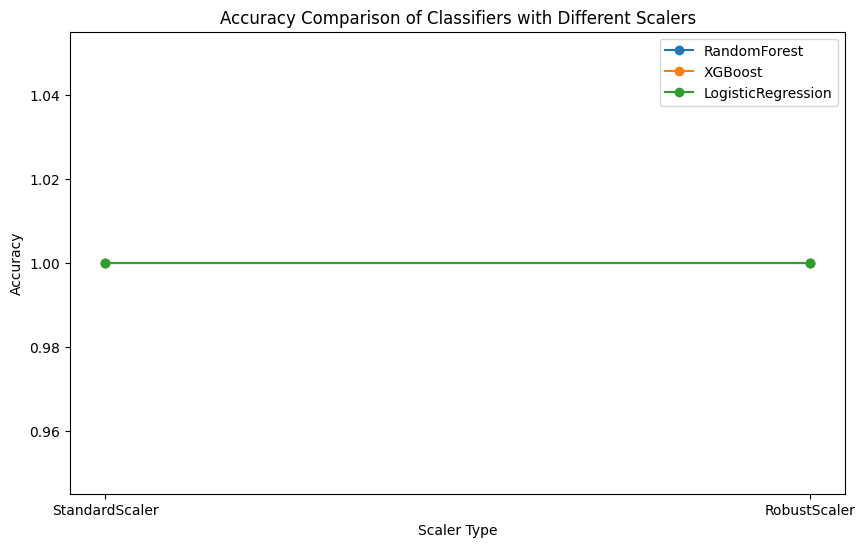

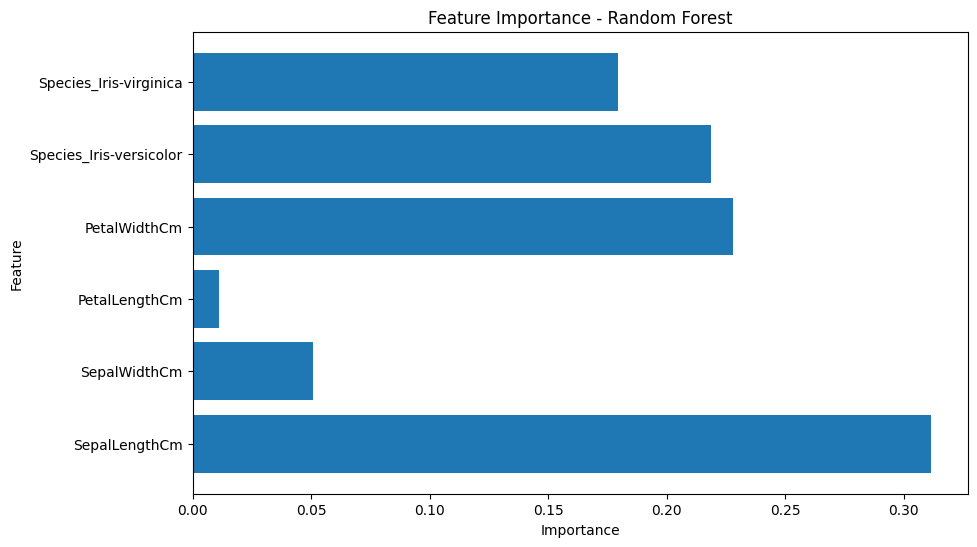

PCA - Random Forest Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [48]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score

# Encode the target labels as numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Transform the categorical target to numeric labels

# Now perform the same experiment with the encoded target
results = []

for scaler_name, scaler in scalers.items():
    # Apply the scaler to the features
    X_scaled = scaler.fit_transform(X)
    
    for clf_name, clf in classifiers.items():
        # Split data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

        # Train the classifier
        clf.fit(X_train, y_train)
        
        # Evaluate the classifier
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="weighted")
        precision = precision_score(y_test, y_pred, average="weighted")
        recall = recall_score(y_test, y_pred, average="weighted")
        
        # Save results
        results.append({
            'Scaler': scaler_name,
            'Classifier': clf_name,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Precision': precision,
            'Recall': recall
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print results for comparison
print(results_df)

# Step 4: Visualize results
plt.figure(figsize=(10, 6))
for clf_name in classifiers.keys():
    subset = results_df[results_df['Classifier'] == clf_name]
    plt.plot(subset['Scaler'], subset['Accuracy'], label=clf_name, marker='o')

plt.title('Accuracy Comparison of Classifiers with Different Scalers')
plt.xlabel('Scaler Type')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Step 5: Feature Importance (Optional for Random Forest and XGBoost)
# Random Forest
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_scaled, y_encoded)
importances = rf_clf.feature_importances_

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(X.columns, importances)
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Step 6: Evaluate using PCA for dimensionality reduction (optional)
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_scaled)

# Split data and evaluate Random Forest with PCA
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print(f"PCA - Random Forest Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))


Experiment #7: Design and execute another custom experiment. 

Mean Squared Error (MSE): 0.0087
R^2 Score: 0.9875


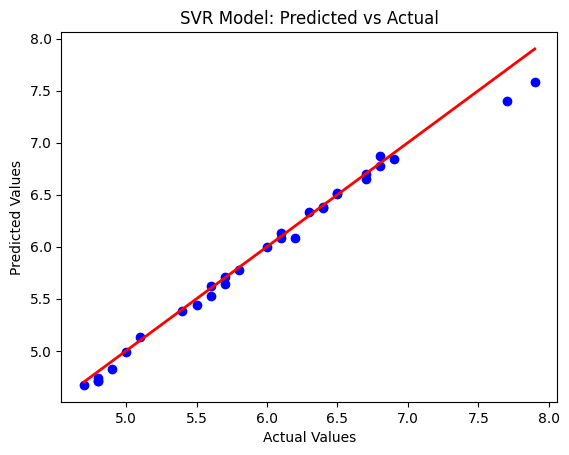

In [49]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris

# Load the Iris dataset
data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.DataFrame(data.target, columns=["target"])

# For regression, we will predict 'sepal length' (the first feature) as a continuous variable.
y = X['sepal length (cm)']  # Using 'sepal length' as the target for regression.

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the SVR model
svr = SVR(kernel='rbf', C=100, epsilon=0.1)

# Train the model
svr.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = svr.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation results
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# Visualize the predictions vs actual values
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.title('SVR Model: Predicted vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


Create meaningful F1-score plots to compare experiments and determine the best model

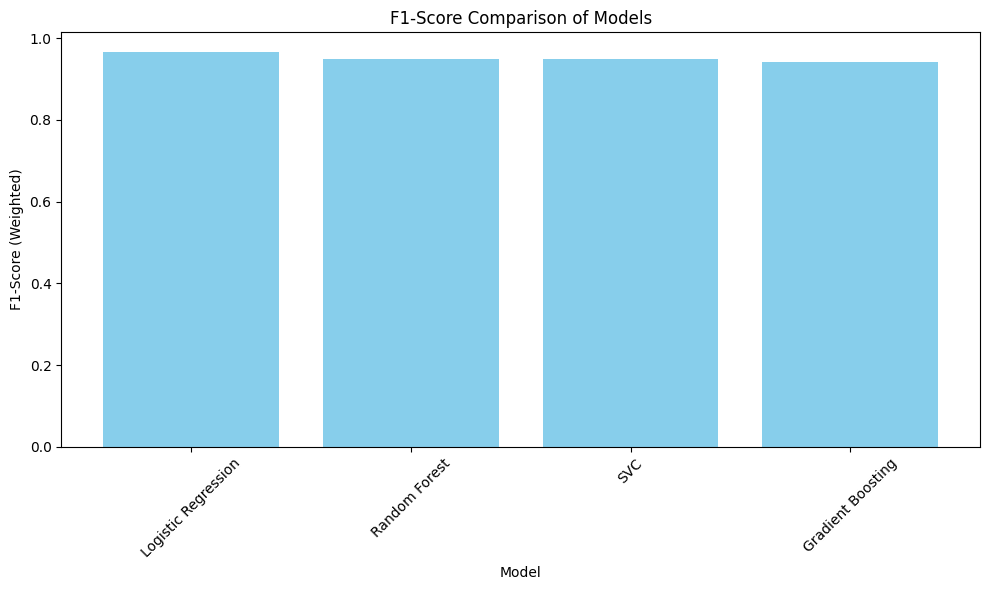

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Load the Iris dataset
data = load_iris()
X = data.data
y = data.target

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Random Forest": RandomForestClassifier(),
    "SVC": SVC(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Create an empty list to store F1-scores
f1_scores = []

# Evaluate each model and calculate F1-score using cross-validation
for model_name, model in models.items():
    # Perform cross-validation and calculate the mean F1-score
    f1 = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted').mean()
    f1_scores.append(f1)

# Plot the F1-scores
plt.figure(figsize=(10, 6))
plt.bar(models.keys(), f1_scores, color='skyblue')
plt.xlabel('Model')
plt.ylabel('F1-Score (Weighted)')
plt.title('F1-Score Comparison of Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [52]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Load the iris dataset
data = load_iris()
X = data.data
y = data.target
target_names = data.target_names

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a Random Forest model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Function to make predictions based on user input
def predict_iris_species(sepal_length, sepal_width, petal_length, petal_width):
    # Create an input array for the model to predict
    input_data = np.array([[sepal_length, sepal_width, petal_length, petal_width]])
    
    # Predict the species
    predicted_class = model.predict(input_data)
    
    # Get the predicted species name
    predicted_species = target_names[predicted_class][0]
    
    return predicted_species

# Input from the user
print("Please enter the following values for the Iris flower:")

sepal_length = float(input("Sepal Length (cm): "))
sepal_width = float(input("Sepal Width (cm): "))
petal_length = float(input("Petal Length (cm): "))
petal_width = float(input("Petal Width (cm): "))

# Make prediction and display the result
predicted_species = predict_iris_species(sepal_length, sepal_width, petal_length, petal_width)
print(f"The predicted species is: {predicted_species}")


Please enter the following values for the Iris flower:
The predicted species is: setosa
